# Task 1

В результате проведения контрольных замеров ключевого параметра продукции была получена следующая выборка данных. Измерения – в миллиметрах. Все вычисления должны быть проведены «вручную» и с использованием ПО (например, Python, Excel и т.п.)
1)	Визуализируйте ваши данные. Что вы можете сказать о них?
2)	Найдите выборочное среднее, моду, медиану и стандартное отклонение. Рассчитайте коэффициент асимметрии и эксцесса.
3)	Выполните проверку данных на «нормальность».
4)	Оцените среднее значение, получив доверительный интервал для среднего значения генеральной совокупности.
5)	Сколько образцов потребуется (размер выборки), чтобы доверительный интервал для среднего не превышал ±0,5 мм?
6)	Найдите выборочный коэффициент вариации. Сделайте выводы о вариабельности выборки.


In [64]:


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [65]:
df = pd.read_csv('../lab-data/lab1.csv')

## 1. Визуализируйте ваши данные. Что вы можете сказать о них?

Text(0.5, 0, 'Measurement')

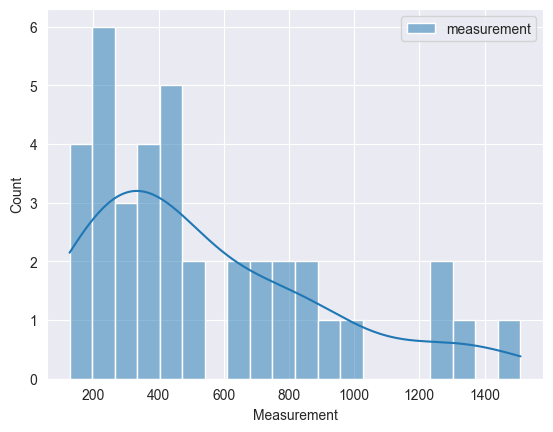

In [66]:
sns.histplot(data=df, bins=20, kde=True)
plt.xlabel('Measurement')

Мы построили гистограмму, из которой понятно, что распределение тримодальное. Наблюдения этой выборки образуют 3 группы по величине измерения.
Можно сделать вывод, что выборка неоднородная.

Можно детальнее рассмотреть данные в отношении Измерение/Индекс.

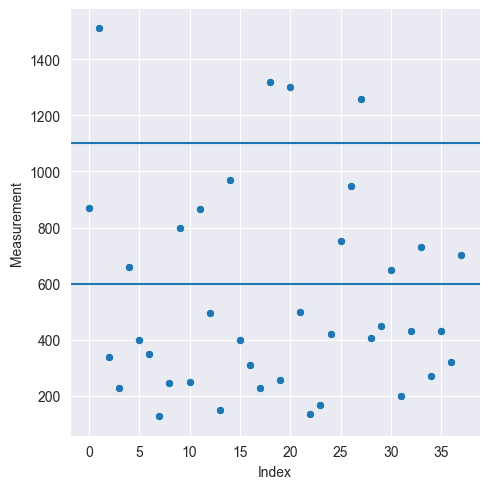

In [67]:
sns.relplot(data=df, x=df.index, y='measurement', )
plt.xlabel('Index')
plt.ylabel('Measurement')
plt.axhline(y=600)
plt.axhline(y=1100)

Возможно стоит рассмотреть каждую группу отдельно.
Для этого выделем 3 группы по признаку Измерение.
Группа 1 - от 0 до 600мм
Группа 2 - от 600 до 1100мм
Группа 3 - от 1100 до ∞

In [68]:
group_extractor = lambda x: 1 if x < 600 else 2 if 600 < x < 1100 else 3

df['group'] = df['measurement'].map(group_extractor)
GROUPS_COUNT = 3
groups = df.groupby('group')


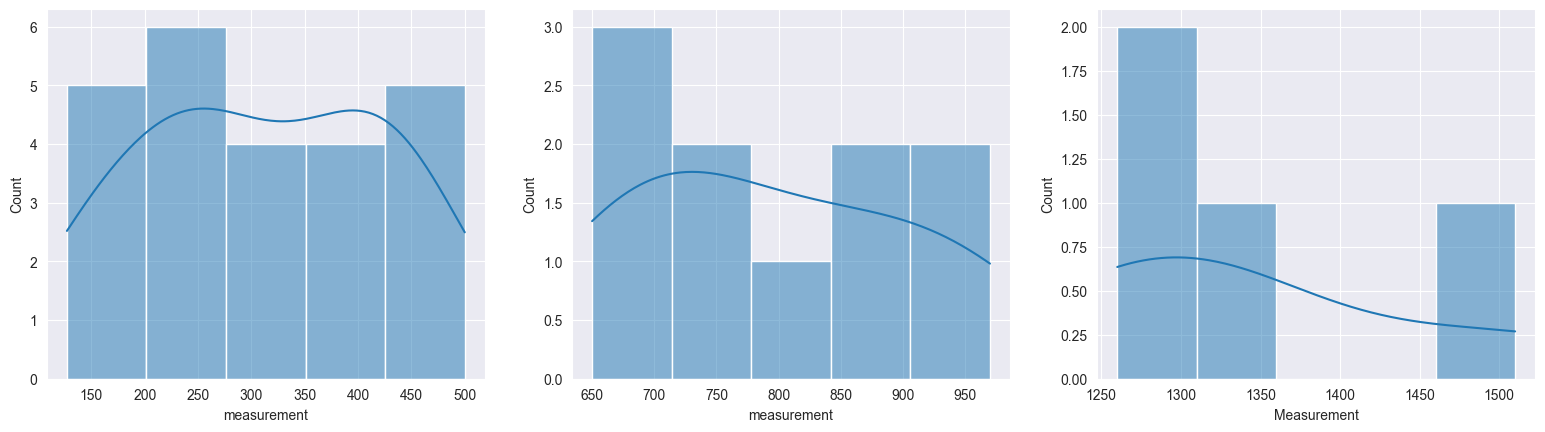

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19.2, 4.8))
for i in range(GROUPS_COUNT):
    sns.histplot(ax=axes[i], data=groups.get_group(i + 1), x='measurement', bins=5, kde=True)
    plt.xlabel('Measurement')

Тут я не понял что у меня получилось. Можно предположить, что группы на такой малой выборке имеют равномерное распределение.

## 2. Найдите выборочное среднее, моду, медиану и стандартное отклонение. Рассчитайте коэффициент асимметрии и эксцесса.

In [70]:
from src.lab1 import sample_mean, sample_mode, sample_median, sample_std, sample_asymmetry_coefficient, \
    sample_excess_coefficient

In [71]:
sample_std(df['measurement'])

360.96574833097947

In [72]:
descriptive_data = []

In [73]:
for i in range(GROUPS_COUNT + 1):
    sample = df.loc[df['group'] == i] if i > 0 else df
    series = sample['measurement']
    descriptive_data.append([
        'Entire sample' if i == 0 else f'Group {i}',
        sample_mean(series),
        sample_mode(series),
        sample_median(series),
        sample_std(series),
        sample_asymmetry_coefficient(series),
        sample_excess_coefficient(series)
    ])

In [74]:
descriptive_data = pd.DataFrame(descriptive_data, columns=[
    'Sample',
    'Mean',
    'Mode',
    'Median',
    'Std',
    'Asymmetry C',
    'Excess C'
])
descriptive_data

,Sample,Mean,Mode,Median,Std,Asymmetry C,Excess C
0,Entire sample,548.789474,430,430.0,360.965748,0.329088,6.231823e+12
1,Group 1,313.166667,430,330.5,112.773618,-1.035999,-6.742941e+09
2,Group 2,794.800000,650,833.0,109.340569,1.324303,1.850516e+09
3,Group 3,1347.500000,1260,1415.0,96.274348,0.908861,8.379398e+08


Мода и медиана одинаковы, но стоит отметить, что чувствуется синтетичность данных. Так как только одно измерение повторилось дважды и оно его значение совпало с медианой. 
Для нормального распределения коэффициент ассиметрии = 0, а эксцесса = 3. Свойства не соответствуют нормальному распределению.

## 3. Выполните проверку данных на «нормальность».

### Q-Q Plot

Есть два графических способа проверить распределение выборки на нормальность - Q-Q график и гистограмма.
Гистограмма уже есть.
Рендерим Q-Q.

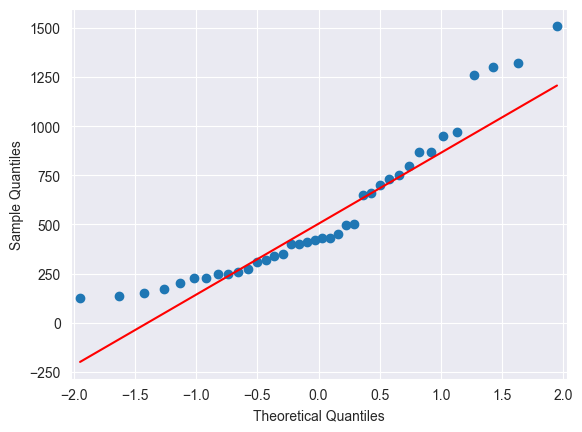

In [75]:
import statsmodels.api as sm

_ = sm.qqplot(data=df['measurement'], loc=0, scale=1, line='q')

### Тест Шапиро-Уилка

In [76]:
from scipy.stats import shapiro

ALPHA = 0.05
stat, p = shapiro(df['measurement'])
print(f"p {('bigger' if p > ALPHA else 'less')} then alpha")

p less then alpha


Так как значение меньше 0.05 отклоняем гипотезу

### Тест Колмогорова-Смирнова

In [77]:
from scipy.stats import kstest

stat, p = kstest(df['measurement'], 'norm')
print(f"p {('bigger' if p > ALPHA else 'less')} then alpha")

p less then alpha


Так как значение меньше 0.05 отклоняем гипотезу

## 4. Оцените среднее значение, получив доверительный интервал для среднего значения генеральной совокупности.

In [78]:
from math import sqrt

n = len(df)
x = sample_mean(df['measurement'])
std = sample_std(df['measurement'])

z = 0.95
diff = z * (std / sqrt(n))
[x - diff, x + diff]

[493.1609158441189, 604.4180315243021]

Вероятность того, что доверительный интервал [493.1609158441189, 604.4180315243021] содержит истинное среднее значение измерения равна 95%.

## 5. Сколько образцов потребуется (размер выборки), чтобы доверительный интервал для среднего не превышал ±0,5 мм?

In [79]:
from math import ceil

ceil((z * std / 0.5) ** 2)

470370

Из формулы доверенного интервала выносим размер выборки и подставляем нужную погрешность.
Можно проверить подставив в исходную формулу получившееся значение

In [80]:
z * (std / sqrt(470370))

0.4999997555115587

## 6. Найдите выборочный коэффициент вариации. Сделайте выводы о вариабельности выборки.

In [81]:
sample_std(df['measurement']) / sample_mean(df['measurement'])

0.6577490379100998

Выборка неоднородная